In [1]:
%ls

'Data sets'/       'Notebook Saves'/   README.md   Results/
 Dreem_functions/   Our_functions/     RP.ipynb


In [2]:
import os
import time
import copy
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from scipy import signal
import librosa
import librosa.display

from tqdm import trange
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

plt.rcParams["figure.figsize"] = (5, 5)

In [111]:
from Dreem_functions.visualisation import SIGNALS_NAME, extract_events_from_binary_mask, \
                                          visualize_signal_and_event, visualise_index
from Dreem_functions.metric_dreem  import jaccard_overlap, extract_events_from_binary_mask, \
                                          compute_f1_score, compute_tp_fp_fn_for_each_entry,\
                                          format_predictions_for_scoring, dreem_sleep_apnea_custom_metric
from Our_functions.create_tensors  import normalize_dim, normalize_ppson, compute_spectrograms
from Our_functions.create_datasets import create_dataset, create_3_part_dataset, create_4_part_dataset, \
                                          create_loader
from Our_functions.raw_models      import RawCNN, GruCNN
from Our_functions.fft_models      import fftCNN
from Our_functions.dual_models     import DualCNN
from Our_functions.loss_functions  import DiceBCELoss, TverskyLoss, FocalLoss

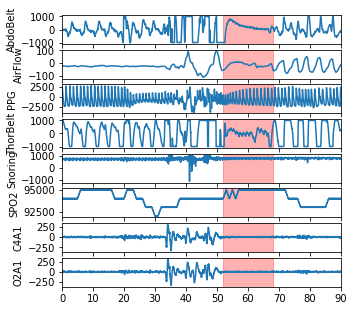

In [4]:
# Visualize signals

PATH_TO_TRAINING_DATA = "Data sets/additional_files_dreem/X_train.h5"
PATH_TO_TRAINING_TARGET = "Data sets/Training/y_train_tX9Br0C.csv"
h5_file = h5py.File(PATH_TO_TRAINING_DATA)
mask = np.array(pd.read_csv(PATH_TO_TRAINING_TARGET))
visualise_index(0, h5_file, mask)

In [5]:
# Create training data
print("Train set...")

PATH_TO_TRAINING_DATA = "Data sets/additional_files_dreem/X_train.h5"
train_file = h5py.File(PATH_TO_TRAINING_DATA)

train_set = train_file['data'][:, 2:]

train_set_raw = train_set.reshape((4400, 8, 9000))
train_set_fft = compute_spectrograms(train_set_raw, status='log')
train_set_raw = normalize_ppson(train_set_raw)


# Create testing data
print("Test  set...")

PATH_TO_TESTING_DATA = "Data sets/additional_files_dreem/X_test.h5"
test_file = h5py.File(PATH_TO_TESTING_DATA)

test_set = test_file['data'][:, 2:]

test_set_raw = test_set.reshape((4400, 8, 9000))
test_set_fft = compute_spectrograms(test_set_raw, status='log')
test_set_raw = normalize_ppson(test_set_raw)


# Create training label
PATH_TO_TRAINING_TARGET = "Data sets/Training/y_train_tX9Br0C.csv"
masks = np.array(pd.read_csv(PATH_TO_TRAINING_TARGET))
masks = np.array(masks[:, 1:])

print("1D Input  shapes: {}".format(train_set_raw.shape))
print("2D Input  shapes: {}".format(train_set_fft.shape))
print("Output    shapes: {}".format(masks.shape))

Train set...


100%|██████████| 4400/4400 [00:02<00:00, 2023.56it/s]


Test  set...


100%|██████████| 4400/4400 [00:02<00:00, 2075.86it/s]

1D Input  shapes: (4400, 8, 9000)
2D Input  shapes: (4400, 8, 100, 90)
Output    shapes: (4400, 90)


In [80]:
# Create dataset. Splitting into 5 for ensemble method.
train_dataset_dual = create_3_part_dataset(train_set_raw, train_set_fft, masks)

split1_dual = torch.utils.data.Subset(train_dataset_dual, range(0 * 880, 1 * 880))
split2_dual = torch.utils.data.Subset(train_dataset_dual, range(1 * 880, 2 * 880))
split3_dual = torch.utils.data.Subset(train_dataset_dual, range(2 * 880, 3 * 880))
split4_dual = torch.utils.data.Subset(train_dataset_dual, range(3 * 880, 4 * 880))
split5_dual = torch.utils.data.Subset(train_dataset_dual, range(4 * 880, 5 * 880))

splits_dual = [split1_dual, split2_dual, split3_dual, split4_dual, split5_dual]

In [81]:
rawmodel = RawCNN().cuda()

summary(rawmodel, (8, 9000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 9000]           3,872
         MaxPool1d-2              [-1, 32, 900]               0
              ReLU-3              [-1, 32, 900]               0
           Dropout-4              [-1, 32, 900]               0
            Conv1d-5              [-1, 64, 900]          43,072
         MaxPool1d-6               [-1, 64, 90]               0
              ReLU-7               [-1, 64, 90]               0
           Dropout-8               [-1, 64, 90]               0
            Conv1d-9               [-1, 32, 90]          51,232
             ReLU-10               [-1, 32, 90]               0
          Dropout-11               [-1, 32, 90]               0
           Linear-12                  [-1, 256]         737,536
             ReLU-13                  [-1, 256]               0
           Linear-14                   

In [82]:
grumodel = GruCNN().cuda()

summary(grumodel, (8, 9000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 9000]           3,872
         MaxPool1d-2              [-1, 32, 900]               0
              ReLU-3              [-1, 32, 900]               0
           Dropout-4              [-1, 32, 900]               0
            Conv1d-5              [-1, 64, 900]          43,072
         MaxPool1d-6               [-1, 64, 90]               0
              ReLU-7               [-1, 64, 90]               0
           Dropout-8               [-1, 64, 90]               0
            Conv1d-9               [-1, 32, 90]          51,232
             ReLU-10               [-1, 32, 90]               0
          Dropout-11               [-1, 32, 90]               0
              GRU-12  [[-1, 2, 32], [-1, 2, 32]]               0
           Linear-13                  [-1, 256]         737,536
             ReLU-14                  

In [83]:
dualmodel = DualCNN().cuda()

# summary(dualmodel, ((8, 100, 90), (8, 9000)))

In [84]:
fftmodel = fftCNN().cuda()

summary(fftmodel, (8, 100, 90))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 100, 90]           3,872
              ReLU-2          [-1, 32, 100, 90]               0
         MaxPool2d-3           [-1, 32, 50, 90]               0
           Dropout-4           [-1, 32, 50, 90]               0
            Conv2d-5           [-1, 64, 50, 90]          38,976
              ReLU-6           [-1, 64, 50, 90]               0
         MaxPool2d-7           [-1, 64, 25, 90]               0
           Dropout-8           [-1, 64, 25, 90]               0
            Conv2d-9          [-1, 128, 25, 90]         188,544
             ReLU-10          [-1, 128, 25, 90]               0
        MaxPool2d-11          [-1, 128, 12, 90]               0
          Dropout-12          [-1, 128, 12, 90]               0
           Conv2d-13           [-1, 64, 12, 90]         221,248
             ReLU-14           [-1, 64,

In [107]:
def train_model(model, train_loader, val_loader, model_index):
    model_file = 'Results/new_experiment' + '/' + 'dualcnn_' + str(model_index) + '.pth'
    
    criterion = TverskyLoss() # alternative: look at loss_functions.py or torch.nn.BCELoss()
    
    lr = 0.0001
        
    since = time.time()
    num_epochs = 100
    
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

    best_acc = 0.
    thresh = 0.5

    for epoch in range(num_epochs):
        epoch_acc = 0.0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()

                for batch_idx, (raw, fft, target) in enumerate(train_loader):
                    if use_cuda:
                        raw, fft, target = raw.cuda(), fft.cuda(), target.cuda()

                    optimizer.zero_grad()
                    
                    # Input varies depending on network used
                    output = model(raw)
                    
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

            else:
                model.eval()
                
                # Temporary output file for k-fold
                outfile = 'Results/new_experiment/fold_results{}.csv'.format(model_index)
                
                # Compute validation loss
                validation_loss = 0
                
                for batch_idx, (raw, fft, target) in enumerate(val_loader):
                    if use_cuda:
                        raw, fft, target = raw.cuda(), fft.cuda(), target.cuda()

                    # Input varies depending on network used
                    output = model(raw)
                    
                    validation_loss += criterion(output, target).item()
                    
                validation_loss = validation_loss / (batch_idx + 1)
                
                # Compute F1 score
                output_file = open(outfile, "w")
                output_file.write("ID,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,y_13,y_14,y_15,y_16,y_17,y_18,y_19,"
                                     "y_20,y_21,y_22,y_23,y_24,y_25,y_26,y_27,y_28,y_29,y_30,y_31,y_32,y_33,y_34,y_35,y_36,y_37,"
                                     "y_38,y_39,y_40,y_41,y_42,y_43,y_44,y_45,y_46,y_47,y_48,y_49,y_50,y_51,y_52,y_53,y_54,y_55,"
                                     "y_56,y_57,y_58,y_59,y_60,y_61,y_62,y_63,y_64,y_65,y_66,y_67,y_68,y_69,y_70,y_71,y_72,y_73,"
                                     "y_74,y_75,y_76,y_77,y_78,y_79,y_80,y_81,y_82,y_83,y_84,y_85,y_86,y_87,y_88,y_89\n")
                
                for f in range(880 * model_index, 880 * model_index + 880, 1):
                    fft = train_set_fft[f, :, :, :]
                    raw = train_set_raw[f, :, :]
                    
                    fft = fft.reshape((1, fft.shape[0], fft.shape[1], fft.shape[2]))
                    fft = torch.tensor(fft, dtype=torch.float)
                    
                    raw = raw.reshape((1, raw.shape[0], raw.shape[1]))
                    raw = torch.tensor(raw, dtype=torch.float)

                    if use_cuda:
                        fft = fft.cuda()
                        raw = raw.cuda()

                    # Do not Sigmoid result unless BCEWithLogit is used
                    output1 = model(raw)[0].cpu().detach().numpy()
                    output1 = output1 > thresh
                    output1 = output1.astype(int)

                    my_list = [4400+f] + list(output1)
                    my_string = ','.join(map(str, my_list)) 

                    output_file.write("%s\n" % (my_string))

                output_file.close()
                
                CSV_FILE_Y_TRUE = 'Data sets/K-fold train sets/y_train_{}.csv'.format(model_index + 1)
                CSV_FILE_Y_PRED = 'Results/new_experiment/fold_results{}.csv'.format(model_index)
                df_y_true = pd.read_csv(CSV_FILE_Y_TRUE, index_col=0, sep=',')
                df_y_pred = pd.read_csv(CSV_FILE_Y_PRED, index_col=0, sep=',')
                
                try:
                    custom_res = dreem_sleep_apnea_custom_metric(df_y_true, df_y_pred)
                except ZeroDivisionError:
                    print("--> Zero division occurred.")
                    custom_res = 0.

                print('Epoch {} --> validation set: mean loss: {:.3f}. F1 score: {:.3f}'.format(epoch, validation_loss, custom_res))
                
                epoch_acc = custom_res
            
            # Save model if F1 score is better
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), model_file)
                print('--> Saved model to ' + model_file)
        
        # Every XX epochs, decrease lr and load best val weights to model for optimization
        if (epoch % 150 == 0 and epoch != 0):
            lr = lr * 0.1
            
            print("\nNew leaning rate ({}) and model weights!".format(lr))
            
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
                
            state_dict = torch.load(model_file)
            model.load_state_dict(state_dict)
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    return model

In [108]:
# Create experiment folder
if not os.path.isdir('Results/new_experiment'):
    os.makedirs('Results/new_experiment')

batch_size = 100

use_cuda = torch.cuda.is_available()

for x in range(5):
    l = []

    for i in range(5):
        if (i == x):
            continue
        else:
            l.append(splits_dual[i])

    models = GruCNN()

    if (use_cuda == True):
      models.cuda()
    
    set_to_use = torch.utils.data.ConcatDataset(l)

    train_loader = torch.utils.data.DataLoader(set_to_use, batch_size=batch_size, shuffle=False, num_workers=1)
    val_loader = torch.utils.data.DataLoader(splits_dual[x], batch_size=batch_size, shuffle=False)    
    models = train_model(models, train_loader, val_loader, x)

Epoch 0 --> validation set: mean loss: 0.872. F1 score: 0.048
--> Saved model to Results/new_experiment/dualcnn_0.pth
Epoch 1 --> validation set: mean loss: 0.868. F1 score: 0.060
--> Saved model to Results/new_experiment/dualcnn_0.pth
Epoch 2 --> validation set: mean loss: 0.868. F1 score: 0.057
Epoch 3 --> validation set: mean loss: 0.867. F1 score: 0.042
Epoch 4 --> validation set: mean loss: 0.867. F1 score: 0.045
Epoch 5 --> validation set: mean loss: 0.865. F1 score: 0.043
Epoch 6 --> validation set: mean loss: 0.859. F1 score: 0.044
Epoch 7 --> validation set: mean loss: 0.823. F1 score: 0.026
Epoch 8 --> validation set: mean loss: 0.707. F1 score: 0.091
--> Saved model to Results/new_experiment/dualcnn_0.pth
Epoch 9 --> validation set: mean loss: 0.671. F1 score: 0.209
--> Saved model to Results/new_experiment/dualcnn_0.pth
Epoch 10 --> validation set: mean loss: 0.654. F1 score: 0.249
--> Saved model to Results/new_experiment/dualcnn_0.pth
Epoch 11 --> validation set: mean los

In [109]:
use_cuda = torch.cuda.is_available()

model1 = GruCNN()
state_dict1 = torch.load('Results/new_experiment/dualcnn_0.pth')
model1.load_state_dict(state_dict1)
model1.eval()

model2 = GruCNN()
state_dict2 = torch.load('Results/new_experiment/dualcnn_1.pth')
model2.load_state_dict(state_dict2)
model2.eval()

model3 = GruCNN()
state_dict3 = torch.load('Results/new_experiment/dualcnn_2.pth')
model3.load_state_dict(state_dict3)
model3.eval()

model4 = GruCNN()
state_dict4 = torch.load('Results/new_experiment/dualcnn_3.pth')
model4.load_state_dict(state_dict4)
model4.eval()

model5 = GruCNN()
state_dict5 = torch.load('Results/new_experiment/dualcnn_4.pth')
model5.load_state_dict(state_dict5)
model5.eval()

outfile = 'Results/new_experiment/gru_results.csv'

if use_cuda:
    print('Using GPU')
    model1.cuda()
    model2.cuda()
    model3.cuda()
    model4.cuda()
    model5.cuda()
else:
    print('Using CPU')

output_file = open(outfile, "w")
output_file.write("ID,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,y_13,y_14,y_15,y_16,y_17,y_18,y_19,"
                     "y_20,y_21,y_22,y_23,y_24,y_25,y_26,y_27,y_28,y_29,y_30,y_31,y_32,y_33,y_34,y_35,y_36,y_37,"
                     "y_38,y_39,y_40,y_41,y_42,y_43,y_44,y_45,y_46,y_47,y_48,y_49,y_50,y_51,y_52,y_53,y_54,y_55,"
                     "y_56,y_57,y_58,y_59,y_60,y_61,y_62,y_63,y_64,y_65,y_66,y_67,y_68,y_69,y_70,y_71,y_72,y_73,"
                     "y_74,y_75,y_76,y_77,y_78,y_79,y_80,y_81,y_82,y_83,y_84,y_85,y_86,y_87,y_88,y_89\n")
thresh = 0.5

for f in trange(test_set_raw.shape[0]):
    raw = test_set_raw[f, :, :]
    raw = raw.reshape((1, raw.shape[0], raw.shape[1]))
    raw = torch.tensor(raw, dtype=torch.float)
    
    fft = test_set_fft[f, :, :, :]
    fft = raw.reshape((1, fft.shape[0], fft.shape[1], fft.shape[2]))
    fft = torch.tensor(fft, dtype=torch.float)

    if use_cuda:
        raw = raw.cuda()
    
    output1 = model1(raw)[0].cpu().detach().numpy()
    output1 = output1 > thresh
    output1 = output1.astype(int)
    
    output2 = model2(raw)[0].cpu().detach().numpy()
    output2 = output2 > thresh
    output2 = output2.astype(int)
    
    output3 = model3(raw)[0].cpu().detach().numpy()
    output3 = output3 > thresh
    output3 = output3.astype(int)
    
    output4 = model4(raw)[0].cpu().detach().numpy()
    output4 = output4 > thresh
    output4 = output4.astype(int)
    
    output5 = model5(raw)[0].cpu().detach().numpy()
    output5 = output5 > thresh
    output5 = output5.astype(int)

    sum = (output1 + output2 + output3 + output4 + output5) / 5
    sum = np.rint(sum).astype(int)

    my_list = [4400+f] + list(sum)
    my_string = ','.join(map(str, my_list)) 

    output_file.write("%s\n" % (my_string))

output_file.close()

print("\nSuccesfully wrote " + outfile + ', you can upload this file to the challenge competition website')

  0%|          | 8/4400 [00:00<01:01, 71.70it/s]

Using GPU


100%|██████████| 4400/4400 [01:00<00:00, 73.12it/s]


Succesfully wrote Results/new_experiment/gru_results.csv, you can upload this file to the challenge competition website


In [110]:
# Comparison with baseline
if __name__ == '__main__':
    CSV_FILE_Y_TRUE = 'Data sets/Results/y_benchmark.csv'
    CSV_FILE_Y_PRED = 'Results/new_experiment/gru_results.csv'
    df_y_true = pd.read_csv(CSV_FILE_Y_TRUE, index_col=0, sep=',')
    df_y_pred = pd.read_csv(CSV_FILE_Y_PRED, index_col=0, sep=',')
    print(dreem_sleep_apnea_custom_metric(df_y_true, df_y_pred))

0.5294771968854283
